# WaDi A1 - Notebook 5: Binary Classification  
* **Input:** Feature matrix parquet from Notebook 4
* **Scope:** Binary classification - normal (0) vs anomaly (1). Where anomaly includes both cyber attacks and sensor faults. Trains a Logistic Regression baseline and Random Forest primary model. Establishes detection performance before the three-class problem in Notebook 6
* **Output:** Trained model artifact, classification report, confusion matrix

# Stage 0 - Setup

## 0.1 - Imports and Paths

In [1]:
from __future__ import annotations

from pathlib import Path
from datetime import datetime, timezone
import json
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 180)

# Paths 
WORK_DIR     = Path("work")
PROJECT_DIR  = WORK_DIR / "wadi_A1"
DATA_DIR     = PROJECT_DIR / "data"
FEATURES_DIR = DATA_DIR / "features"
MODELS_DIR   = PROJECT_DIR / "models"
RESULTS_DIR  = PROJECT_DIR / "results"
REF_DIR      = DATA_DIR / "reference"
RUN_DIR      = REF_DIR / "pipeline_runs"

for p in [MODELS_DIR, RESULTS_DIR, RUN_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project:  ", PROJECT_DIR)
print("Features: ", FEATURES_DIR)
print("Models:   ", MODELS_DIR)
print("Results:  ", RESULTS_DIR)

Project:   work/wadi_A1
Features:  work/wadi_A1/data/features
Models:    work/wadi_A1/models
Results:   work/wadi_A1/results


## 0.2 - Helper Utilities

In [2]:
class PipelineError(RuntimeError):
    pass

def utc_now_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def write_json(path: Path, obj: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(obj, indent=2, default=str))

def read_json(path: Path) -> dict:
    return json.loads(path.read_text())

def print_classification_report(y_true, y_pred, labels, target_names):
    report = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        digits=4,
    )
    print(report)
    return report

def plot_confusion_matrix(y_true, y_pred, labels, display_labels, title, path):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()
    print(f"Saved: {path}")
    return cm.tolist()

print("Helpers ready.")

Helpers ready.


## 0.3 - Configuration

In [3]:
DATASET_NAME = "WaDi.A1_9 Oct 2017"
RANDOM_SEED  = 42
RUN_ID       = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S_utc")

TEST_NORMAL_HOLDOUT_PCT = 0.20   # fraction of train normal rows held out for test evaluation

# Binary label mapping
BINARY_LABELS      = [0, 1]
BINARY_TARGET_NAMES = ["normal", "anomaly"]

# Logistic Regression config
LR_MAX_ITER = 1000

# Random Forest — default then tuned
RF_N_ESTIMATORS  = 100
RF_RANDOM_STATE  = RANDOM_SEED

print(f"Dataset:     {DATASET_NAME}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Run ID:      {RUN_ID}")
print(f"Labels:      {dict(zip(BINARY_LABELS, BINARY_TARGET_NAMES))}")

Dataset:     WaDi.A1_9 Oct 2017
Random seed: 42
Run ID:      20260223_145035_utc
Labels:      {0: 'normal', 1: 'anomaly'}


# Stage 1 - Load Feature Matrix  
Loads the feature matrix from Notebook 4 and the canonical `FEATURE_COLS` reference. All downstream stages operate on these inputs

## 1.1 - Load Matrix

In [4]:
# Load most recent feature matrix parquet
feature_files = sorted(FEATURES_DIR.glob("wadi_features_*.parquet"))
if not feature_files:
    raise PipelineError(f"No feature matrix found in {FEATURES_DIR}")

features_path = feature_files[-1]
print(f"Loading: {features_path}")

df = pd.read_parquet(features_path)
print(f"Shape:   {df.shape}")

print(f"\nLabel distribution:")
for label_val, label_name in [(0, "normal"), (1, "attack"), (2, "fault")]:
    n   = (df["label"] == label_val).sum()
    pct = n / len(df) * 100
    print(f"  {label_name:<8} ({label_val}): {n:>9,}  ({pct:.2f}%)")

print(f"\nSplit distribution:")
for split in ["train", "test"]:
    n = (df["split"] == split).sum()
    print(f"  {split:<6}: {n:>9,}")

Loading: work/wadi_A1/data/features/wadi_features_20260223_142554_utc.parquet
Shape:   (1382402, 573)

Label distribution:
  normal   (0): 1,116,251  (80.75%)
  attack   (1):   172,801  (12.50%)
  fault    (2):    93,350  (6.75%)

Split distribution:
  train : 1,209,601
  test  :   172,801


## 1.2 - Load Column List

In [5]:
# Load canonical feature column list
feature_cols_path = REF_DIR / "feature_cols.json"
if not feature_cols_path.exists():
    raise PipelineError(f"feature_cols.json not found at {feature_cols_path}")

feature_ref  = read_json(feature_cols_path)
FEATURE_COLS = feature_ref["feature_cols"]

print(f"FEATURE_COLS loaded: {len(FEATURE_COLS)} features")
print(f"Source run ID:       {feature_ref['run_id']}")

missing = [c for c in FEATURE_COLS if c not in df.columns]
if missing:
    raise PipelineError(f"FEATURE_COLS missing from feature matrix: {missing}")

print("All FEATURE_COLS present in feature matrix.")

FEATURE_COLS loaded: 570 features
Source run ID:       20260223_142554_utc
All FEATURE_COLS present in feature matrix.


# Stage 2 - Prepare Binary Labels  
Collapses the three-class labels into binary: normal (0) vs anomaly (1).  
Cyber attacks and sensor faults are both treated as anomalies at this stage.  
The goal is to establish how well the model can detect any deviation from normal operation before attempting to distinguish between anomaly types in Notebook 6.

## 2.1 - Collapse Labels

In [6]:
# Collapse attack (1) and fault (2) into anomaly (1)
df["label_binary"] = df["label"].apply(lambda x: 0 if x == 0 else 1).astype("int8")

print("Binary label mapping:")
print("  normal (0) -> 0  (unchanged)")
print("  attack (1) -> 1  (anomaly)")
print("  fault  (2) -> 1  (anomaly)")

Binary label mapping:
  normal (0) -> 0  (unchanged)
  attack (1) -> 1  (anomaly)
  fault  (2) -> 1  (anomaly)


## 2.2 - Carve Test-Normal Holdout from Train
Holds out the last 20% of train normal rows by timestamp to create a mixed test set containing both normal and attack rows. This temporal holdout ensures the test normal rows represent the Oct 6–9 pre-attack period, the most challenging normal period in the dataset.

In [7]:
# Hold out last 20% of train normal rows by timestamp
normal_train_idx = df[
    (df["split"] == "train") & (df["label"] == 0)
].sort_values("timestamp").index

cutoff = int(len(normal_train_idx) * (1.0 - TEST_NORMAL_HOLDOUT_PCT))
test_normal_idx = normal_train_idx[cutoff:]

df.loc[test_normal_idx, "split"] = "test_normal"

print(f"Train normal rows kept:      {len(normal_train_idx) - len(test_normal_idx):,}")
print(f"Test normal rows held out:   {len(test_normal_idx):,}")
print(f"Attack rows (original test): {(df['split'] == 'test').sum():,}")

Train normal rows kept:      893,000
Test normal rows held out:   223,251
Attack rows (original test): 172,801


## 2.3 - Binary Label Distribution

In [8]:
print("Binary label distribution:\n")

# Train
train_df_disp = df[df["split"] == "train"]
n0 = (train_df_disp["label_binary"] == 0).sum()
n1 = (train_df_disp["label_binary"] == 1).sum()
total = len(train_df_disp)
print(f"  train:")
print(f"    normal  (0): {n0:>8,}  ({n0/total*100:.2f}%)")
print(f"    anomaly (1): {n1:>8,}  ({n1/total*100:.2f}%)")
print(f"    total:       {total:>8,}\n")

# Combined test (normal holdout + attack)
test_df_disp = df[df["split"].isin(["test_normal", "test"])]
n0 = (test_df_disp["label_binary"] == 0).sum()
n1 = (test_df_disp["label_binary"] == 1).sum()
total = len(test_df_disp)
print(f"  test (combined):")
print(f"    normal  (0): {n0:>8,}  ({n0/total*100:.2f}%)")
print(f"    anomaly (1): {n1:>8,}  ({n1/total*100:.2f}%)")
print(f"    total:       {total:>8,}")

Binary label distribution:

  train:
    normal  (0):  893,000  (90.54%)
    anomaly (1):   93,350  (9.46%)
    total:        986,350

  test (combined):
    normal  (0):  223,251  (56.37%)
    anomaly (1):  172,801  (43.63%)
    total:        396,052


# Stage 3 - Baseline: Logistic Regression
Trains a Logistic Regression classifier as a linear baseline.  
Provides a performance floor to compare Random Forest against

## 3.1 - Prepare and Train

In [9]:
train_df = df[df["split"] == "train"]
test_df  = df[df["split"].isin(["test_normal", "test"])]

X_train = train_df[FEATURE_COLS].values
y_train = train_df["label_binary"].values

X_test  = test_df[FEATURE_COLS].values
y_test  = test_df["label_binary"].values

print(f"Train: X={X_train.shape}  normal={( y_train==0).sum():,}  anomaly={(y_train==1).sum():,}")
print(f"Test:  X={X_test.shape}  normal={(y_test==0).sum():,}  anomaly={(y_test==1).sum():,}")

print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=LR_MAX_ITER, random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
print("Done.")

Train: X=(986350, 570)  normal=893,000  anomaly=93,350
Test:  X=(396052, 570)  normal=223,251  anomaly=172,801

Training Logistic Regression...
Done.


## 3.2 - Evaluate

Logistic Regression — Test Split Results (baseline)
              precision    recall  f1-score   support

      normal     0.8794    0.1839    0.3042    223251
     anomaly     0.4785    0.9674    0.6403    172801

    accuracy                         0.5258    396052
   macro avg     0.6790    0.5757    0.4723    396052
weighted avg     0.7045    0.5258    0.4509    396052



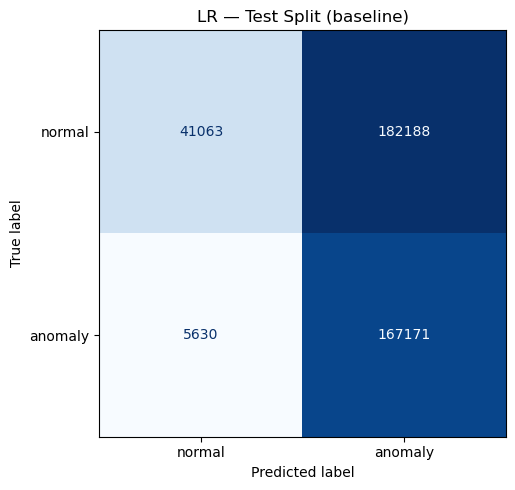

Saved: work/wadi_A1/results/lr_test_confusion_matrix_20260223_145035_utc.png


In [10]:
y_pred_lr_test = lr.predict(X_test)

print("Logistic Regression — Test Split Results (baseline)")
print("=" * 50)
lr_report = print_classification_report(
    y_test, y_pred_lr_test,
    labels       = BINARY_LABELS,
    target_names = BINARY_TARGET_NAMES,
)
lr_cm = plot_confusion_matrix(
    y_test, y_pred_lr_test,
    labels         = BINARY_LABELS,
    display_labels = BINARY_TARGET_NAMES,
    title          = "LR — Test Split (baseline)",
    path           = RESULTS_DIR / f"lr_test_confusion_matrix_{RUN_ID}.png",
)

# Stage 4 - Primary Model: Random Forest  
Trains a Random Forest classifier as the primary model. Random Forest handles class imbalance reasonably well, is robust to correlated features and provides feature importances for interpretability.

## 4.1 - Train the Random Forest Model

In [11]:
# Train Random Forest with default hyperparameters 
import time

print("Training Random Forest (default hyperparameters)...")
print(f"  n_estimators={RF_N_ESTIMATORS}, random_state={RF_RANDOM_STATE}\n")

t0 = time.time()
rf = RandomForestClassifier(
    n_estimators = RF_N_ESTIMATORS,
    random_state = RF_RANDOM_STATE,
    oob_score    = True,
    n_jobs       = -1,
)
rf.fit(X_train, y_train)
elapsed = time.time() - t0
print(f"Done. Elapsed: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"OOB score: {rf.oob_score_:.4f}")


Training Random Forest (default hyperparameters)...
  n_estimators=100, random_state=42

Done. Elapsed: 261.9s (4.4 min)
OOB score: 0.9996


## 4.2 - Define Operating Points via Threshold Sweep  
Thresholds selected on OOB scores  

<table style="text-align:left;">
    <tr>
        <th>Operating Point</th>
        <th>Threshold</th>
        <th>Priority</th>
    </tr>
    <tr>
        <td>High Recall</td>
        <td>0.2</td>
        <td>Minimize missed attacks</td>
    </tr>
    <tr>
        <td>Balanced</td>
        <td>0.4</td>
        <td>Balance precision and recall</td>
    </tr>
    <tr>
        <td>High Precision</td>
        <td>0.6</td>
        <td>Minimize false alarms</td>
    </tr>
</table>

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

OPERATING_POINTS = {
    "high_recall":    0.2,
    "balanced":       0.4,
    "high_precision": 0.6,
}

# Use OOB decision function for threshold selection
y_prob_oob = rf.oob_decision_function_[:, 1]

op_results = {}

print("Random Forest — OOB Threshold Selection")
print("=" * 84)
print(f"{'Operating Point':<20} {'Threshold':<12} {'Precision':<12} "
      f"{'Recall':<12} {'F1':<12} {'False Pos':<12} {'False Neg'}")
print("-" * 84)

for op_name, threshold in OPERATING_POINTS.items():
    y_pred_t = (y_prob_oob >= threshold).astype(int)
    p   = precision_score(y_train, y_pred_t, zero_division=0)
    r   = recall_score(y_train, y_pred_t)
    f1  = f1_score(y_train, y_pred_t)
    cm  = confusion_matrix(y_train, y_pred_t)
    fp  = cm[0, 1]
    fn  = cm[1, 0]

    op_results[op_name] = {
        "threshold": threshold,
        "precision": round(p, 4),
        "recall":    round(r, 4),
        "f1":        round(f1, 4),
        "false_pos": int(fp),
        "false_neg": int(fn),
    }

    print(f"  {op_name:<18} {threshold:<12.1f} {p:<12.4f} "
          f"{r:<12.4f} {f1:<12.4f} {fp:<12,} {fn:,}")

Random Forest — OOB Threshold Selection
Operating Point      Threshold    Precision    Recall       F1           False Pos    False Neg
------------------------------------------------------------------------------------
  high_recall        0.2          0.9954       0.9998       0.9976       435          20
  balanced           0.4          0.9974       0.9987       0.9980       246          121
  high_precision     0.6          0.9990       0.9971       0.9980       95           275


## 4.3 - Final Evaluation: Test Split
Applies all three operating points to the held-out test split.
Test set contains held-out normal rows (last 20% of train normal, by timestamp)
combined with all original attack rows. Neither group was used in training
or threshold selection.

Random Forest — Test Split Final Results

  [high_recall]  threshold=0.2
              precision    recall  f1-score   support

      normal     0.9998    0.0187    0.0367    223251
     anomaly     0.4410    1.0000    0.6120    172801

    accuracy                         0.4468    396052
   macro avg     0.7204    0.5093    0.3244    396052
weighted avg     0.7559    0.4468    0.2877    396052



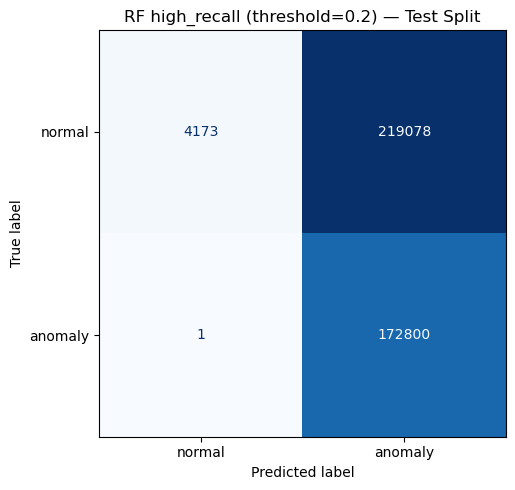

Saved: work/wadi_A1/results/rf_high_recall_test_confusion_matrix_20260223_145035_utc.png

  [balanced]  threshold=0.4
              precision    recall  f1-score   support

      normal     0.5541    0.0624    0.1122    223251
     anomaly     0.4357    0.9351    0.5944    172801

    accuracy                         0.4432    396052
   macro avg     0.4949    0.4988    0.3533    396052
weighted avg     0.5024    0.4432    0.3226    396052



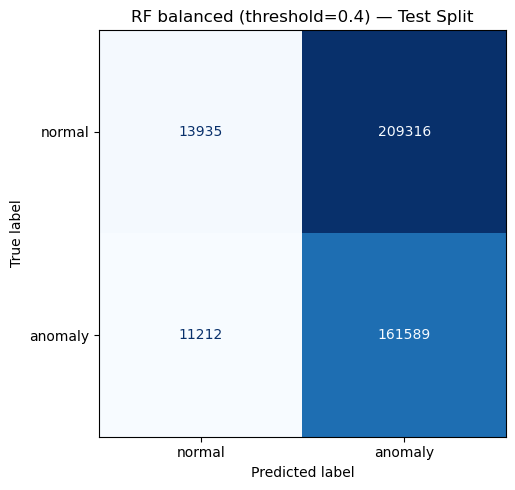

Saved: work/wadi_A1/results/rf_balanced_test_confusion_matrix_20260223_145035_utc.png

  [high_precision]  threshold=0.6
              precision    recall  f1-score   support

      normal     0.3056    0.1204    0.1727    223251
     anomaly     0.3626    0.6466    0.4647    172801

    accuracy                         0.3500    396052
   macro avg     0.3341    0.3835    0.3187    396052
weighted avg     0.3305    0.3500    0.3001    396052



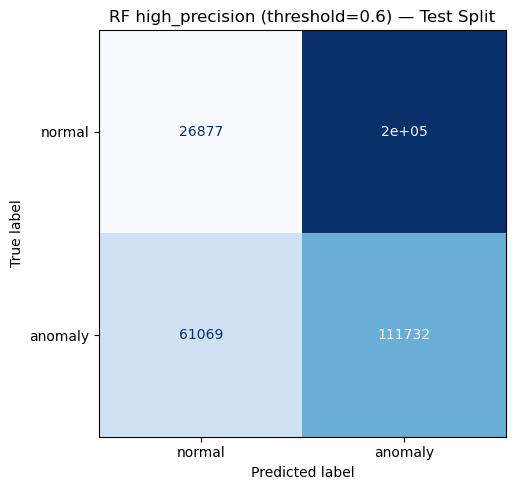

Saved: work/wadi_A1/results/rf_high_precision_test_confusion_matrix_20260223_145035_utc.png

Test Split Summary
Operating Point      Threshold    Precision    Recall       F1           False Pos    False Neg
------------------------------------------------------------------------------------
  high_recall        0.2          0.4410       1.0000       0.6120       219,078      1
  balanced           0.4          0.4357       0.9351       0.5944       209,316      11,212
  high_precision     0.6          0.3626       0.6466       0.4647       196,374      61,069


In [18]:
# Prepare test arrays 
test_df = df[df["split"].isin(["test_normal", "test"])]
X_test  = test_df[FEATURE_COLS].values
y_test  = test_df["label_binary"].values

# Get anomaly probabilities on test split
y_prob_rf_test = rf.predict_proba(X_test)[:, 1]

test_results = {}

print("Random Forest — Test Split Final Results")
print("=" * 60)

for op_name, threshold in OPERATING_POINTS.items():
    y_pred_t = (y_prob_rf_test >= threshold).astype(int)
    p   = precision_score(y_test, y_pred_t, zero_division=0)
    r   = recall_score(y_test, y_pred_t)
    f1  = f1_score(y_test, y_pred_t)
    cm  = confusion_matrix(y_test, y_pred_t)
    fp  = cm[0, 1]
    fn  = cm[1, 0]

    test_results[op_name] = {
        "threshold": threshold,
        "precision": round(p, 4),
        "recall":    round(r, 4),
        "f1":        round(f1, 4),
        "false_pos": int(fp),
        "false_neg": int(fn),
    }

    print(f"\n  [{op_name}]  threshold={threshold}")
    report = print_classification_report(
        y_test, y_pred_t,
        labels       = BINARY_LABELS,
        target_names = BINARY_TARGET_NAMES,
    )

    plot_confusion_matrix(
        y_test, y_pred_t,
        labels         = BINARY_LABELS,
        display_labels = BINARY_TARGET_NAMES,
        title          = f"RF {op_name} (threshold={threshold}) — Test Split",
        path           = RESULTS_DIR / f"rf_{op_name}_test_confusion_matrix_{RUN_ID}.png",
    )

# Summary table 
print("\nTest Split Summary")
print("=" * 60)
print(f"{'Operating Point':<20} {'Threshold':<12} {'Precision':<12} "
      f"{'Recall':<12} {'F1':<12} {'False Pos':<12} {'False Neg'}")
print("-" * 84)
for op_name, res in test_results.items():
    print(f"  {op_name:<18} {res['threshold']:<12.1f} {res['precision']:<12.4f} "
          f"{res['recall']:<12.4f} {res['f1']:<12.4f} "
          f"{res['false_pos']:<12,} {res['false_neg']:,}")

# Stage 5 - Feature Importance

## 5.1 - Top Features

Top 20 Features by Importance
   1. 1_AIT_003_PV__min_60s                          0.0203
   2. 2A_AIT_004_PV__max_60s                         0.0175
   3. 1_AIT_003_PV__mean_60s                         0.0165
   4. 1_AIT_004_PV__min_60s                          0.0151
   5. 1_AIT_004_PV__max_60s                          0.0146
   6. 1_AIT_003_PV__max_60s                          0.0146
   7. 1_AIT_004_PV__mean_60s                         0.0145
   8. 1_AIT_003_PV                                   0.0129
   9. 2A_AIT_004_PV__min_60s                         0.0128
  10. 1_AIT_004_PV                                   0.0124
  11. 1_AIT_001_PV__mean_60s                         0.0101
  12. 2A_AIT_004_PV                                  0.0101
  13. 1_AIT_001_PV__min_60s                          0.0100
  14. 1_AIT_001_PV__max_60s                          0.0095
  15. 2A_AIT_004_PV__mean_60s                        0.0093
  16. 2B_AIT_004_PV__max_60s                         0.0090
  17. 2B_A

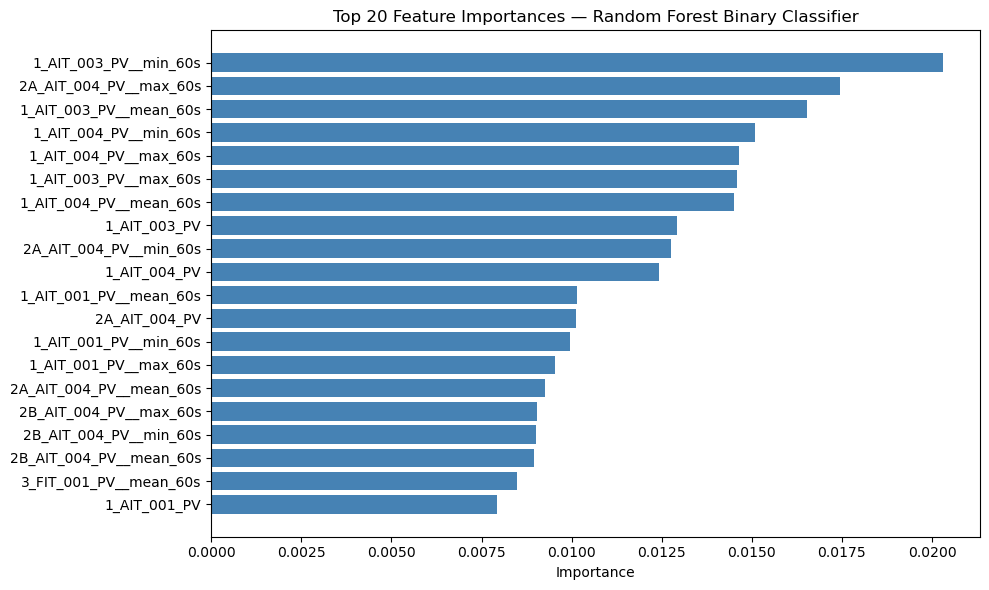

Saved: work/wadi_A1/results/rf_feature_importance_20260223_145035_utc.png


In [19]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]

print("Top 20 Features by Importance")
print("=" * 60)
for rank, idx in enumerate(indices, 1):
    print(f"  {rank:>2}. {FEATURE_COLS[idx]:<45s}  {importances[idx]:.4f}")

# Save plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    [FEATURE_COLS[i] for i in indices[::-1]],
    importances[indices[::-1]],
    color="steelblue"
)
ax.set_xlabel("Importance")
ax.set_title("Top 20 Feature Importances — Random Forest Binary Classifier")
plt.tight_layout()
feat_imp_path = RESULTS_DIR / f"rf_feature_importance_{RUN_ID}.png"
plt.savefig(feat_imp_path, dpi=150)
plt.show()
print(f"Saved: {feat_imp_path}")

# Stage 6 - Artifacts

## 6.1 - Save Model

In [20]:
model_path = MODELS_DIR / f"rf_binary_{RUN_ID}.joblib"
joblib.dump(rf, model_path)
print(f"Model saved: {model_path}")

Model saved: work/wadi_A1/models/rf_binary_20260223_145035_utc.joblib


## 6.2 - Run Log

In [21]:
run_log = {
    "run_id":         RUN_ID,
    "created_at_utc": utc_now_iso(),
    "stage":          "Notebook 5 — Binary Classification",
    "dataset":        DATASET_NAME,
    "inputs": {
        "feature_matrix": str(features_path),
        "feature_cols":   str(feature_cols_path),
    },
    "outputs": {
        "model": str(model_path),
    },
    "configuration": {
        "n_estimators":    RF_N_ESTIMATORS,
        "random_state":    RF_RANDOM_STATE,
        "oob_score":       True,
        "train_rows":      int(X_train.shape[0]),
        "test_rows":       int(X_test.shape[0]),
        "n_features":      len(FEATURE_COLS),
        "test_normal_holdout_pct": TEST_NORMAL_HOLDOUT_PCT,
    },
    "oob_score": round(float(rf.oob_score_), 4),
    "oob_threshold_selection": op_results,
    "test_results": test_results,
    "notes": [
        "Test set = last 20% of train normal rows (by timestamp) + all attack rows.",
        "High false positive rate on normal holdout rows reflects temporal "
        "distribution shift in Oct 6-9 normal period, documented WaDi dataset property.",
        "Threshold selection performed on OOB scores",
    ],
}

run_log_path = RUN_DIR / f"run_{RUN_ID}.json"
write_json(run_log_path, run_log)
print(f"Run log written: {run_log_path}")

Run log written: work/wadi_A1/data/reference/pipeline_runs/run_20260223_145035_utc.json


# Stage 7 - Reflection

In [23]:
reflection = [
    ("Binary task definition",
     "Normal (0) vs anomaly (1), where anomaly = cyber attack OR sensor fault. "
     "Establishes detection baseline before the three-class problem in Notebook 6."),

    ("Test set construction",
     "Test set = last 20% of train normal rows (by timestamp, ~223k rows) + "
     "all 172,801 attack rows. Temporal holdout ensures test normals are from "
     "the Oct 6-9 pre-attack period — the most challenging normal period in the dataset."),

    ("Logistic Regression baseline",
     "LR achieved poor normal recall (0.18) on test — the linear decision boundary "
     "predicts nearly everything as anomaly, achieving high anomaly recall (0.97) "
     "at the cost of near-complete failure on normal classification. "
     "Confirms need for a nonlinear model that can learn the boundary geometry."),

    ("Random Forest results",
     f"OOB score: {rf.oob_score_:.4f}. High recall operating point (threshold=0.2) "
     f"achieved recall={test_results['high_recall']['recall']:.4f} on attacks "
     f"with {test_results['high_recall']['false_pos']:,} false positives on normal holdout. "
     "Precision ceiling limited by temporal distribution shift in test normals."),

    ("Temporal distribution shift",
     "High false positive rate on Oct 6-9 normal rows is a known WaDi dataset "
     "property (Turrin et al.) — normal behavior drifts in the pre-attack period. "
     "The model correctly learned Sep 25 - Oct 6 normal behavior; the Oct 6-9 "
     "period looks anomalous by that standard. Documented as dataset limitation."),

    ("Implication for Notebook 6",
     "Binary classification is limited by temporal drift. The three-class problem "
     "reframes the question: given an anomaly, can we distinguish attack from fault? "
     "This is the novel contribution and does not require normal rows in test."),

    ("Next step",
     "Notebook 6 — Three-Class Classification. Trains on train split (normal + fault), "
     "evaluates on test split (attack only). Primary metric: can the model correctly "
     "classify attacks as attacks rather than faults?"),
]

print("Pipeline Reflection")
print("=" * 60)
for title, content in reflection:
    print(f"\n[{title}]")
    print(f"  {content}")

Pipeline Reflection

[Binary task definition]
  Normal (0) vs anomaly (1), where anomaly = cyber attack OR sensor fault. Establishes detection baseline before the three-class problem in Notebook 6.

[Test set construction]
  Test set = last 20% of train normal rows (by timestamp, ~223k rows) + all 172,801 attack rows. Temporal holdout ensures test normals are from the Oct 6-9 pre-attack period — the most challenging normal period in the dataset.

[Logistic Regression baseline]
  LR achieved poor normal recall (0.18) on test — the linear decision boundary predicts nearly everything as anomaly, achieving high anomaly recall (0.97) at the cost of near-complete failure on normal classification. Confirms need for a nonlinear model that can learn the boundary geometry.

[Random Forest results]
  OOB score: 0.9996. High recall operating point (threshold=0.2) achieved recall=1.0000 on attacks with 219,078 false positives on normal holdout. Precision ceiling limited by temporal distribution shi

# This continues with WaDi A1 Notebook 6 - Three-Class Classification

# TODO: 

* Look into WaDi A2 - It might solve some of my dataset issues
* Look into creating train/test split with random windows.
* Look into creating train/test split by putting one day of attack data into each
* Look into how I am injecting faults, should it be both train/test, or only train
* Look into comparing Tennessee eastman dataset to my injected fualts. Need to justify my methodology